# Scenario analysis - creating a heatmap

The following sections extend the analysis presented in the [previous tutorial](/tutorials/scenario-analysis-line-plot). Instead of examining relationships between a single system parameter and a single system variable it is also worthwhile exploring how the joint interaction of two or more system parameters affects dispatch outcomes. 

Building on the preceeding tutorial, in addition to augmenting the Demand Forecast for South Australia, the Demand Forecast for Victoria will also be modified. The goal of the analysis is to investigate how jointly varying these parameters would likely impact power flow over the Heywood interconnector, and also energy prices in South Australia. Results will be presented in the form of heatmaps, allowing the data to be visually represented in three dimensions. Note the same methods can be used to examine relationships between other system parameters and variables.


## Imports and authentication

In [1]:
import os
import json
import itertools

import requests
import xmltodict
import numpy as np
from dotenv import load_dotenv

from jsonpath_ng import jsonpath
from jsonpath_ng.ext import parse

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Base URL endpoint for the NEMDE API
base_url = 'http://nemde-api-host:8080/api/v1/'

## Load case file

In [2]:
def convert_casefile(path_to_file):
    """Load a historical NEMDE case file and convert it to a dict"""

    # Read case file contents
    with open(path_to_file, 'r') as f:
        casefile = f.read()

    # Force these nodes to always return lists
    force_list = ('Trade', 'TradeTypePriceStructure',)

    return xmltodict.parse(casefile, force_list=force_list)


def load_casefile(case_id):
    """Load case file"""
    
    # Load case file and convert to JSON
    casefile = convert_casefile(f'../../data/NEMSPDOutputs_{case_id}00.loaded')
   
    return casefile

# Load case file
case_id = '20210401001'
casefile = load_casefile(case_id=case_id)

## Approach
As in the previous tutorial the downloaded case file will be treated as our canonical 'source of truth'. This 'base' case file will always be loaded prior to performing updates.

The following two functions are used to update Demand Forecast parameters within a case file.

In [3]:
def update_region_demand_forecast(casefile, region_id, value):
    """
    Load case file and update demand forecast for a given region
    
    Parameter
    ---------
    casefile : dict
        Case information
    
    region_id : str
        Region for which Demand Forecast should be modified
    
    value : float
        New value for Demand Forecast parameter
        
    Returns
    -------
    casefile : dict
        Case file with updated Demand Forecast parameter
    """
    
    # Construct JSON path expression
    expression = (f"NEMSPDCaseFile \
                  .NemSpdInputs \
                  .PeriodCollection \
                  .Period \
                  .RegionPeriodCollection \
                  .RegionPeriod[?(@RegionID=='{region_id}')] \
                  .@DF")

    jsonpath_expr = parse(expression)

    # Update value
    jsonpath_expr.update(casefile, value)
    
    return casefile


def update_casefile(case_id, region_1, value_1, region_2, value_2):
    """
    Update Demand Forecast parameters in two regions
    
    Parameters
    ----------
    case_id : str
        Case ID for base case file
    
    region_1 : str
        First NEM region for which Demand Forecast should be updated
    
    value_1 : float
        New Demand Forecast value for region_1
    
    region_2 : str
        Second NEM region for which Demand Forecast should be updated
    
    value_2 : float
        New Demand Forecast value for region_2
    
    Returns
    -------
    casefile : dict
        Updated case file
    """
    
    # Load 'base' case file
    casefile = load_casefile(case_id=case_id)
    
    # Update parameters in both regions
    casefile = update_region_demand_forecast(casefile=casefile, region_id=region_1, 
                                            value=value_1)

    casefile = update_region_demand_forecast(casefile=casefile, region_id=region_2, 
                                            value=value_2)

    return casefile

Jobs can be submitted to the online queue, with job IDs recorded so it's possible to map job results to parameters.

In [4]:
def submit_jobs(base_url, region_1, region_2, demand_forecasts):
    """Submit jobs to queue"""
    
    values = [i for i in itertools.product(demand_forecasts, demand_forecasts)]
    
    jobs = []
    for value_1, value_2 in values:
        # Construct request body - using augmented casefiles
        body = {"casefile": update_casefile(case_id='20210401001',
                                            region_1=region_1, value_1=value_1,
                                            region_2=region_2, value_2=value_2)}

        # Submit request and extract job ID
        url = base_url + 'jobs/create'
        response = requests.post(url=url, json=body)
        job_info = response.json()

        # Construct a map between the job ID, job info and the value of the parameter used in the analysis
        job_id = job_info.get('job_id')
        
        parameters = {
            'region_1': region_1, 'value_1': value_1,
            'region_2': region_2, 'value_2': value_2
        }
        
        jobs.append({'job_info': job_info, 'parameters': parameters})

    return jobs        

# Create jobs with different Demand Forecast parameters
demand_forecasts = [i for i in range(-200, 201, 100)]
jobs = submit_jobs(base_url=base_url, region_1='SA1', region_2='VIC1',
                   demand_forecasts=demand_forecasts)

The status of all jobs can be checked by using the following endpoint:

`http://nemde-api-host/api/v1/jobs/status/list`

In [5]:
def get_status_list(base_url):
    """Get job status list"""

    url = base_url + 'jobs/status/list'
    response = requests.get(url=url)
    
    return response.json()


# Get status of each job
status = get_status_list(base_url=base_url)

# Number of remaining jobs
remaining_jobs = len([i for i in status if i.get('status') != 'finished'])
print('Jobs remaining:', remaining_jobs)

# Only print the first three jobs (to save space)
status[:3]

Jobs remaining: 0


[{'job_id': 'f9c7a37b-aef9-47c0-bd99-f34b0b7376ba',
  'status': 'finished',
  'created_at': '2021-08-07T14:21:00.201861Z',
  'enqueued_at': '2021-08-07T14:21:00.336259Z',
  'started_at': '2021-08-07T14:26:24.145864Z',
  'ended_at': '2021-08-07T14:27:07.703582Z',
  'timeout': '180',
  'label': None},
 {'job_id': 'c3a83710-3b93-4111-be28-c89fd1fcdab9',
  'status': 'finished',
  'created_at': '2021-08-07T14:20:57.995084Z',
  'enqueued_at': '2021-08-07T14:20:58.150456Z',
  'started_at': '2021-08-07T14:25:49.352415Z',
  'ended_at': '2021-08-07T14:26:35.754458Z',
  'timeout': '180',
  'label': None},
 {'job_id': '9211fab6-b322-413d-92d5-c4b2fde95087',
  'status': 'finished',
  'created_at': '2021-08-07T14:20:55.740010Z',
  'enqueued_at': '2021-08-07T14:20:55.891435Z',
  'started_at': '2021-08-07T14:25:38.257121Z',
  'ended_at': '2021-08-07T14:26:23.892678Z',
  'timeout': '180',
  'label': None}]

## Retrieve results
Once the jobs have finished results can be retrieved from the queue.

In [6]:
def get_job_results(base_url, job_ids):
    """Get job results"""
    
    results = []
    for job_id in job_ids:
        # Construct URL used to obtain results
        url = base_url + f'jobs/{job_id}/results'
        print("Job results URL:", url)

        # Submit request and retrieve job results
        response = requests.get(url=url)
        results.append(response.json())
        
    return results


# Get all job IDs for which results should be returned
job_ids = [i.get('job_info').get('job_id') for i in jobs]

# Load job results
job_results = get_job_results(base_url=base_url, job_ids=job_ids)

Job results URL: http://nemde-api-host:8080/api/v1/jobs/901d2cf9-6339-42c3-9fad-9deeb78ae8fa/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/d9aabe8f-65f1-4175-a3bf-e6c7c5ca329d/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/53d6b4a8-c53f-4bf2-9206-f24b63281737/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/61055210-54b4-49b8-aca1-fd1d62de3220/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/2bff544e-0ef4-4d9c-9eeb-9dae1a46272f/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/36e1c546-ef8b-46ba-b238-fe8bc3dcaed2/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/ce00c3a2-dcb3-4a0d-9374-d24300916fbd/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/6b46cf58-17da-46e2-93bd-d89fa3155c00/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/8003b171-6082-4439-86ce-dfeacc240ef3/results
Job results URL: http://nemde-api-host:8080/api/v1/jobs/b280a52f-8e49-4555-804a-cb5ae3177e9

### Map parameters to job IDs
The first step is to map job IDs to job parameters.

In [7]:
def get_job_parameters(jobs):
    """Extract job parameters and map to job ID"""

    return {job.get('job_info').get('job_id'): job.get('parameters') for job in jobs}


job_parameters = get_job_parameters(jobs=jobs)

Optionally save results. It is good practice to save results after retrieving them from the queue. Re-analysing results simply requires loading the saved results, rather than having to re-run jobs.

In [8]:
import pickle

def save_results(job_parameters, job_results):
    """Save results to notebook directory"""
    
    output_dir = os.path.abspath(os.path.join(os.path.curdir, 'output'))
    
    with open(os.path.join(output_dir, 'job_results.pickle'), 'wb') as f:
        pickle.dump(job_results, f)

    with open(os.path.join(output_dir, 'job_parameters.pickle'), 'wb') as f:
        pickle.dump(job_parameters, f)
        
        
def load_results():
    """Save results to notebook directory"""
    
    output_dir = os.path.abspath(os.path.join(os.path.curdir, 'output'))
    
    with open(os.path.join(output_dir, 'job_results.pickle'), 'rb') as f:
        pickle.dump(job_results, f)

    with open(os.path.join(output_dir, 'job_parameters.pickle'), 'rb') as f:
        pickle.dump(job_parameters, f)
        
    return job_parameters, job_results


# Save / load results if required
save_results(job_parameters=job_parameters, job_results=job_results)
# job_parameters, job_results = load_results()

### Map results to job IDs
The next step is to map results to job IDs. The following function searches a results dictionary for a target value corresponding to a given JSON path expression.

In [9]:
def get_target_value(results, expression):
    """Extract value from results dictionary given a JSON path expression"""
    
    jsonpath_expr = parse(expression)   
    values = [match.value for match in jsonpath_expr.find(results)]
    
    # Only one value should be returned
    if len(values) != 1:
        raise Exception("Should only return 1 value, encountered", len(values))

    return values[0]

Functions can now be used to extract target values (energy prices in South Australia and power flow over the Heywood interconnector) and map them to their respective job IDs.

In [10]:
def get_sa_energy_price(job_results):
    """Extract energy price from results dictionary"""
    
    expression = (f"results \
                  .output \
                  .RegionSolution[?(@RegionID='SA1')] \
                  .@EnergyPrice")

    prices = {i.get('job_id'): get_target_value(results=i, expression=expression)
              for i in job_results}
    
    return prices


def get_v_sa_flow(job_results):
    """Extract V-SA (Heywood) interconnector flow"""
    
    expression = (f"results \
                  .output \
                  .InterconnectorSolution[?(@InterconnectorID='V-SA')] \
                  .@Flow")

    flow = {i.get('job_id'): get_target_value(results=i, expression=expression)
            for i in job_results}
    
    return flow

## Plotting
A heatmap can be used to visualise the results in three dimensions. The horizontal and vertical axes will display the Demand Forecast parameters used when running the model, while colour will indicate value of the variable under investigation.

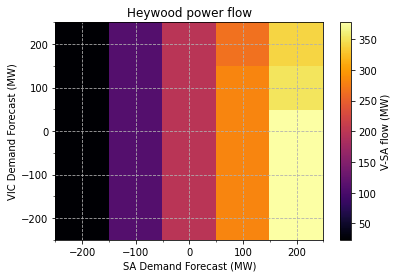

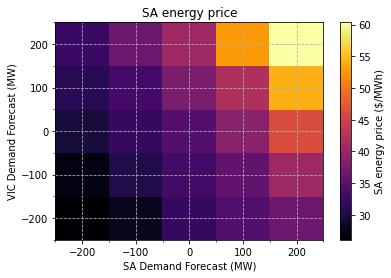

In [11]:
def get_plot_data(job_parameters, job_results, func):
    """
    Organise plot data
    
    Parameters
    ----------
    job_parameters : dict
        Parameters used when augmenting case files
    
    job_results : list
        Contains solution to mathematical program reported by worker
    
    func : function
        Function used to extract values from job_results
    
    Returns
    -------
    x : numpy array
        x-axis values used in plot
    
    y : numpy array
        y-axis values used in plot
    
    z : numpy array
        z-axis values used in plot
    """

    # Extract job results - dict indexed by job ID {job_id: target_value, ...}
    values = func(job_results)

    # Organise results {(DF_region_1, DF_region_2): target_value, ...}
    data = {(v.get('value_1'), v.get('value_2')): values.get(job_id)
            for job_id, v in job_parameters.items()}

    # Extract x, y, z components
    x = np.array([k[0] for k in data.keys()])
    y = np.array([k[1] for k in data.keys()])
    z = np.array([v for v in data.values()])

    # Add shape information to array - required when plotting
    x.shape = (5, 5)
    y.shape = (5, 5)
    z.shape = (5, 5)

    return x, y, z


def format_tick_locations(ax):
    """Adjust tick spacing"""
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
    
    return ax


def plot_v_sa_flow(job_parameters, job_results, shading=None):
    """V-SA interconnector flow as a function of SA and VIC demand forecasts"""
    
    X, Y, Z = get_plot_data(job_parameters=job_parameters, job_results=job_results, 
                            func=get_v_sa_flow)

    # Create heatmap and add colour bar
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(X, Y, Z, shading=shading, cmap='inferno')
    cbar = plt.colorbar(mesh)
    
    # Format labels
    ax.set_title('Heywood power flow')
    ax.set_xlabel('SA Demand Forecast (MW)')
    ax.set_ylabel('VIC Demand Forecast (MW)')
    cbar.set_label('V-SA flow (MW)')
    
    ax = format_tick_locations(ax=ax)
    ax.grid(linestyle='--')

    plt.show()
    
    
def plot_sa_energy_price(job_parameters, job_results, shading=None):
    """SA energy price as a function of SA and VIC demand forecasts"""
    
    X, Y, Z = get_plot_data(job_parameters=job_parameters, job_results=job_results, 
                            func=get_sa_energy_price)
    
    # Create heatmap and add colour bar
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(X, Y, Z, shading=shading, cmap='inferno')
    cbar = plt.colorbar(mesh)
    
    # Format labels
    ax.set_title('SA energy price')
    ax.set_xlabel('SA Demand Forecast (MW)')
    ax.set_ylabel('VIC Demand Forecast (MW)')
    cbar.set_label('SA energy price ($/MWh)')
    
    # Format ticks and add grid lines
    ax = format_tick_locations(ax=ax)
    ax.grid(linestyle='--')

    plt.show()


# Create plots
plot_v_sa_flow(job_parameters=job_parameters, job_results=job_results, shading='auto')
plot_sa_energy_price(job_parameters=job_parameters, job_results=job_results, shading='auto')

The resolution of the these plots can be increased by providing a more granual grid over which to explore the solution space. The trade-off is solution time - more jobs must be completed and processed. Interpolation can also be used to smooth the gradient, making it easier to visualise the results.

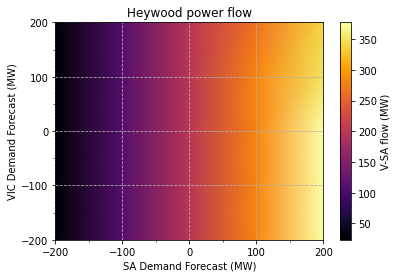

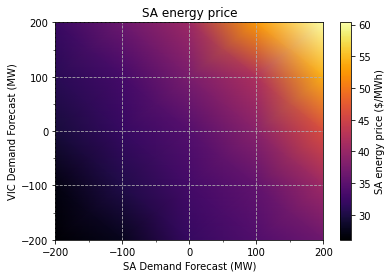

In [12]:
# Create plots with interpolation
plot_v_sa_flow(job_parameters=job_parameters, job_results=job_results, shading='gouraud')
plot_sa_energy_price(job_parameters=job_parameters, job_results=job_results, shading='gouraud')

## Summary
The NEMDE API allows users to explore relationships between the joint interaction of system parameters and system variables. When two system parameters are examined heatmaps can be used to visualise results in three dimensions. This type of scenario analysis can easily be extended to different system parameters and variables, demonstrating the flexibility provided by the NEMDE API when exploring the likely solution space of dispatch outcomes.